<font color = blue><font size = 6> 실험설명 </font></font><br>
이미 이전에 1step에서 RNN기반이 1step의 예측에 대해서 좋지 않다는 것을 몸소 경험했다 하지만 Online-learning에서는 좀 다른 결과가 나올까 기대감에 진행해 보았다<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/4.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.838168
1,0.814640
2,0.801280
3,0.803872
4,0.780264
...,...
38875,0.729952
38876,0.710640
38877,0.736008
38878,0.705272


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/online_learning_seq2seq']

In [5]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [6]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_499860/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
x_seq

tensor([[[0.8382, 0.8146, 0.8013,  ..., 0.8263, 0.8365, 0.8418]],

        [[0.8146, 0.8013, 0.8039,  ..., 0.8365, 0.8418, 0.8420]],

        [[0.8013, 0.8039, 0.7803,  ..., 0.8418, 0.8420, 0.8175]],

        ...,

        [[0.6584, 0.6867, 0.6864,  ..., 0.6986, 0.7334, 0.7053]],

        [[0.6867, 0.6864, 0.7222,  ..., 0.7334, 0.7053, 0.7150]],

        [[0.6864, 0.7222, 0.6899,  ..., 0.7053, 0.7150, 0.7057]]],
       device='cuda:0')

In [12]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-05.
smape 77.62436761014294 %
Adjusting learning rate of group 0 to 9.0250e-05.
smape 38.51970771730643 %
Adjusting learning rate of group 0 to 8.5737e-05.
smape 23.027615699895293 %
Adjusting learning rate of group 0 to 8.1451e-05.
smape 13.770007029698606 %
Adjusting learning rate of group 0 to 7.7378e-05.
smape 10.657403930389917 %
Adjusting learning rate of group 0 to 7.3509e-05.
smape 9.324018113445817 %
Adjusting learning rate of group 0 to 6.9834e-05.
smape 8.475372395886664 %
Adjusting learning rate of group 0 to 6.6342e-05.
smape 7.8882381671832675 %
Adjusting learning rate of group 0 to 6.3025e-05.
smape 7.467682362964366 %
Adjusting learning rate of group 0 to 5.9874e-05.
smape 7.1648160373650445 %
Adjusting learning rate of group 0 to 5.6880e-05.
smape 6.937151247014602 %
Adjusting learning rate of group 0 to 5.4036e-05.
smape 6.75958093909318 %
Adjusting learning rate of group 0 to 5.1334e-05.
smape 6.616135423088021 %
Adjustin

In [14]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 6.640575706958771 %
SMAPE 4.657801605761051 %
SMAPE 3.420193187892437 %
SMAPE 0.2764707896858454 %
SMAPE 4.918103292584419 %
SMAPE 0.6410765419714153 %
SMAPE 4.3438152857124805 %
SMAPE 1.2972156396135688 %
SMAPE 2.978603420779109 %
SMAPE 0.40698105096817017 %
SMAPE 4.45056939125061 %
SMAPE 0.5036064141895622 %
SMAPE 4.288875285536051 %
SMAPE 1.402899551205337 %
SMAPE 4.006618585437536 %
SMAPE 0.12217130492354045 %
SMAPE 2.870713286101818 %
SMAPE 0.8129850607365369 %
SMAPE 2.428570907562971 %
SMAPE 1.7913037203252313 %
SMAPE 2.359042989090085 %
SMAPE 1.7878529075533154 %
SMAPE 1.7548741474747658 %
SMAPE 3.4683747664093967 %
SMAPE 1.6303254961967468 %
SMAPE 3.393156450241804 %
SMAPE 3.1736565828323364 %
SMAPE 4.652342040091753 %
SMAPE 0.7187672797590494 %
SMAPE 4.923941545188427 %
SMAPE 2.635967068374157 %
SMAPE 4.292819578200579 %
SMAPE 4.308273274451494 %
SMAPE 3.654399733990431 %
SMAPE 3.7911316528916355 %
SMAPE 4.404304847121239 %
SMAPE 2.76426013186574 %
SMAPE 4.45376455783844

SMAPE 8.314641505479813 %
SMAPE 2.9868084508925676 %
SMAPE 7.082949839532375 %
SMAPE 2.335435511544347 %
SMAPE 7.23860365897417 %
SMAPE 3.172918539494276 %
SMAPE 7.057424463331699 %
SMAPE 2.6539885569363832 %
SMAPE 8.148854441940784 %
SMAPE 3.776574153453112 %
SMAPE 12.522238336503506 %
SMAPE 5.407100770622492 %
SMAPE 8.967217162251472 %
SMAPE 3.0313190538436174 %
SMAPE 10.233480617403984 %
SMAPE 5.947167754173279 %
SMAPE 10.519693680107594 %
SMAPE 2.0938216410577297 %
SMAPE 12.171977125108242 %
SMAPE 1.3976515727117658 %
SMAPE 11.659044727683067 %
SMAPE 1.957790557295084 %
SMAPE 6.614049747586251 %
SMAPE 0.5386843434534967 %
SMAPE 6.18737131357193 %
SMAPE 3.9488538019359116 %
SMAPE 5.503671128302813 %
SMAPE 3.2502154074609284 %
SMAPE 6.295022010803223 %
SMAPE 2.0603555515408516 %
SMAPE 8.884356051683426 %
SMAPE 0.2970004198141396 %
SMAPE 9.076377354562283 %
SMAPE 0.5662121963687241 %
SMAPE 7.426724061369897 %
SMAPE 1.8735551219433548 %
SMAPE 7.238641381263733 %
SMAPE 1.060457934625446

SMAPE 7.274183988571167 %
SMAPE 5.1655659675598145 %
SMAPE 1.624559232965112 %
SMAPE 3.7012093290686607 %
SMAPE 2.3788901269435883 %
SMAPE 4.070532009005547 %
SMAPE 2.307756345719099 %
SMAPE 3.643498107790947 %
SMAPE 2.930929023772478 %
SMAPE 4.970045819878578 %
SMAPE 1.2755397371947765 %
SMAPE 3.973491750657558 %
SMAPE 3.4206707663834095 %
SMAPE 2.9235432222485542 %
SMAPE 1.9208744410425427 %
SMAPE 2.945402165874839 %
SMAPE 2.9453829284757376 %
SMAPE 2.823827786371112 %
SMAPE 4.013279847800732 %
SMAPE 2.732587406411767 %
SMAPE 3.585447311401367 %
SMAPE 3.8279601596295834 %
SMAPE 3.853826817125082 %
SMAPE 4.205476488918066 %
SMAPE 5.938749197870493 %
SMAPE 5.136017117649317 %
SMAPE 5.9776295609772205 %
SMAPE 4.130479134619236 %
SMAPE 5.357603128999472 %
SMAPE 6.168095778673887 %
SMAPE 6.741650067269803 %
SMAPE 4.883501157164574 %
SMAPE 5.5298346020281315 %
SMAPE 4.372432749718428 %
SMAPE 0.9673775555565953 %
SMAPE 4.239052671939135 %
SMAPE 1.651983354240656 %
SMAPE 4.927690427750349 %


SMAPE 0.8020462552085519 %
SMAPE 1.8943770918995142 %
SMAPE 2.525451624765992 %
SMAPE 3.2666406966745853 %
SMAPE 2.9863947425037622 %
SMAPE 2.419320849701762 %
SMAPE 4.5439047403633595 %
SMAPE 2.4765132796019316 %
SMAPE 3.4141618274152274 %
SMAPE 3.3476265035569672 %
SMAPE 4.888717729598284 %
SMAPE 3.156937027350068 %
SMAPE 5.788336254656315 %
SMAPE 2.8405879214406013 %
SMAPE 5.557066012173891 %
SMAPE 4.328463684767485 %
SMAPE 6.550780318677425 %
SMAPE 4.834665019065142 %
SMAPE 3.6917601972818375 %
SMAPE 3.9242347255349164 %
SMAPE 2.099976686760783 %
SMAPE 3.050126040354371 %
SMAPE 3.271427094936371 %
SMAPE 2.9510415252298117 %
SMAPE 2.8065885715186596 %
SMAPE 4.163120463490486 %
SMAPE 3.369773786514998 %
SMAPE 4.518291309475899 %
SMAPE 1.618983502499759 %
SMAPE 3.999992292374373 %
SMAPE 3.848626594990492 %
SMAPE 2.22054654173553 %
SMAPE 6.031436491757631 %
SMAPE 4.422940470278263 %
SMAPE 5.264445677399635 %
SMAPE 3.4648037515580654 %
SMAPE 6.037980783730745 %
SMAPE 4.593743681907654 %

SMAPE 5.426801949739456 %
SMAPE 4.204864494502544 %
SMAPE 2.7872076481580734 %
SMAPE 4.996197894215584 %
SMAPE 2.6263917591422796 %
SMAPE 4.82010518014431 %
SMAPE 2.227787336334586 %
SMAPE 6.217216361314058 %
SMAPE 2.542262716218829 %
SMAPE 6.17108516395092 %
SMAPE 3.4162973761558533 %
SMAPE 5.573404025286436 %
SMAPE 2.945542685687542 %
SMAPE 5.6966624446213245 %
SMAPE 4.470384359359741 %
SMAPE 5.757620595395565 %
SMAPE 2.5264892671257257 %
SMAPE 6.215295109897852 %
SMAPE 6.041348069906235 %
SMAPE 8.756837897002697 %
SMAPE 4.327261343598366 %
SMAPE 7.7603675946593285 %
SMAPE 7.589329972863197 %
SMAPE 5.789569761604071 %
SMAPE 1.6487087439745665 %
SMAPE 6.884828634560108 %
SMAPE 0.9757837494835258 %
SMAPE 6.323321647942066 %
SMAPE 1.1824074974283576 %
SMAPE 5.629336096346378 %
SMAPE 0.7395057147368789 %
SMAPE 5.039101328700781 %
SMAPE 3.120201086625457 %
SMAPE 6.364719621837139 %
SMAPE 3.3009522929787636 %
SMAPE 5.4765013717114925 %
SMAPE 2.2599251866340637 %
SMAPE 7.5118274092674255 %


SMAPE 7.450494468212128 %
SMAPE 7.309961386024952 %
SMAPE 2.4745993074029684 %
SMAPE 6.565256297588348 %
SMAPE 4.029433008283377 %
SMAPE 8.147576533257961 %
SMAPE 5.4672407023608685 %
SMAPE 5.420424748212099 %
SMAPE 5.905210252851248 %
SMAPE 6.085400283336639 %
SMAPE 1.2479456709697843 %
SMAPE 2.6485641170293093 %
SMAPE 0.5798260038718581 %
SMAPE 0.8898941036313772 %
SMAPE 1.541255934163928 %
SMAPE 3.2097580488771196 %
SMAPE 2.295633079484105 %
SMAPE 2.317401461303234 %
SMAPE 2.3638418279588223 %
SMAPE 2.575406201183796 %
SMAPE 2.920414235442877 %
SMAPE 1.9290357399731874 %
SMAPE 3.6849680542945866 %
SMAPE 0.7973390994593501 %
SMAPE 0.8385016578249632 %
SMAPE 1.5062470957636833 %
SMAPE 3.1144268456846476 %
SMAPE 1.229568561539054 %
SMAPE 3.754990391433239 %
SMAPE 1.5996367642655969 %
SMAPE 3.4395671598613258 %
SMAPE 1.2052955040708184 %
SMAPE 1.779490299522877 %
SMAPE 2.5571267139166594 %
SMAPE 0.9109545834362507 %
SMAPE 0.8701766631565988 %
SMAPE 2.7644326370209455 %
SMAPE 0.413596287

SMAPE 5.634451195597649 %
SMAPE 6.457825757563114 %
SMAPE 5.428807161748409 %
SMAPE 7.519397258758545 %
SMAPE 4.285975486040115 %
SMAPE 2.2799678035080433 %
SMAPE 4.475872173905373 %
SMAPE 4.308000486344099 %
SMAPE 1.787983741611242 %
SMAPE 5.213896814733744 %
SMAPE 3.746235698461533 %
SMAPE 2.436046216636896 %
SMAPE 4.899794727563858 %
SMAPE 3.560473162680864 %
SMAPE 5.043768409639597 %
SMAPE 3.31474032998085 %
SMAPE 2.114769970998168 %
SMAPE 3.56798292696476 %
SMAPE 5.1840461902320385 %
SMAPE 4.459770757704973 %
SMAPE 5.590371731668711 %
SMAPE 3.242488242685795 %
SMAPE 4.869193106889725 %
SMAPE 5.169901844114065 %
SMAPE 5.781305782496929 %
SMAPE 3.4347135126590733 %
SMAPE 3.0557555723935366 %
SMAPE 5.17439017444849 %
SMAPE 9.355201855301857 %
SMAPE 5.313664484769106 %
SMAPE 7.903259053826332 %
SMAPE 5.597576476633549 %
SMAPE 2.672465892508626 %
SMAPE 1.5263427440077066 %
SMAPE 3.3022272922098637 %
SMAPE 1.6638124641031027 %
SMAPE 1.0026556011289358 %
SMAPE 2.464458202943206 %
SMAPE 4

SMAPE 0.8084535957314074 %
SMAPE 3.580633208155632 %
SMAPE 0.15990292391506955 %
SMAPE 2.6052782144397497 %
SMAPE 0.3572751230094582 %
SMAPE 2.766404340043664 %
SMAPE 0.9134679241105914 %
SMAPE 2.5350598599761724 %
SMAPE 1.325886587612331 %
SMAPE 2.0569519829005003 %
SMAPE 2.3225850965827703 %
SMAPE 2.9547221194952726 %
SMAPE 2.507685974240303 %
SMAPE 3.893986858427525 %
SMAPE 2.148383315652609 %
SMAPE 2.278020743280649 %
SMAPE 4.203213423490524 %
SMAPE 2.9247873686254025 %
SMAPE 5.012441482394934 %
SMAPE 2.9669972974807024 %
SMAPE 5.645863365381956 %
SMAPE 3.156422639265657 %
SMAPE 4.736808452755213 %
SMAPE 3.110491316765547 %
SMAPE 6.532720610499382 %
SMAPE 3.544877167791128 %
SMAPE 7.04211563616991 %
SMAPE 4.333284456282854 %
SMAPE 0.9115567123517394 %
SMAPE 1.7090277969837187 %
SMAPE 1.8208787813782692 %
SMAPE 2.1277037039399147 %
SMAPE 3.0127390138804913 %
SMAPE 4.062449064105749 %
SMAPE 3.619836948812008 %
SMAPE 1.5058860704302788 %
SMAPE 5.8292605094611645 %
SMAPE 1.281372074969

SMAPE 5.692366886883974 %
SMAPE 2.276987038552761 %
SMAPE 5.080004397779703 %
SMAPE 4.209355656057596 %
SMAPE 2.5650697089731693 %
SMAPE 3.703665934503078 %
SMAPE 2.7101211678236723 %
SMAPE 1.7358418181538584 %
SMAPE 1.2032325491309166 %
SMAPE 1.796257447451353 %
SMAPE 3.2181949876248837 %
SMAPE 1.6976531837135556 %
SMAPE 4.176291719079018 %
SMAPE 1.0683226501569152 %
SMAPE 4.72930558398366 %
SMAPE 1.4746568351984024 %
SMAPE 5.207254681736231 %
SMAPE 5.1237714141607285 %
SMAPE 2.799097316339612 %
SMAPE 3.7379154339432716 %
SMAPE 6.375118598341942 %
SMAPE 4.271414056420326 %
SMAPE 0.002475129507189422 %
SMAPE 22.192630350589752 %
SMAPE 2.9327428825199604 %
SMAPE 11.06906145811081 %
SMAPE 18.71148891746998 %
SMAPE 2.888063732534647 %
SMAPE 2.7446123007684946 %
SMAPE 8.093983545899391 %
SMAPE 8.717037506401539 %
SMAPE 1.5730965211987495 %
SMAPE 5.524580705910921 %
SMAPE 9.149270288646221 %
SMAPE 6.3787571638822556 %
SMAPE 0.0008617565005124561 %
SMAPE 4.31619580462575 %
SMAPE 4.8163115344

SMAPE 5.146566867828369 %
SMAPE 5.920500610023737 %
SMAPE 5.200365480035543 %
SMAPE 3.619274090975523 %
SMAPE 3.8080299831926823 %
SMAPE 1.3102953666821122 %
SMAPE 1.2928215255960822 %
SMAPE 2.1738352477550507 %
SMAPE 1.828507212921977 %
SMAPE 3.519408822059631 %
SMAPE 3.5436622835695744 %
SMAPE 2.179268606007099 %
SMAPE 2.540591111406684 %
SMAPE 0.6878733080811799 %
SMAPE 0.2279153213603422 %
SMAPE 1.3227020278573036 %
SMAPE 3.844236105680466 %
SMAPE 0.7181957676075399 %
SMAPE 3.34051951020956 %
SMAPE 1.190568620339036 %
SMAPE 6.037628334015608 %
SMAPE 0.8497008173726499 %
SMAPE 3.8551617823541164 %
SMAPE 0.5345059451647103 %
SMAPE 3.5084260888397694 %
SMAPE 2.5018020141869783 %
SMAPE 3.1478268522769213 %
SMAPE 2.9646128434687853 %
SMAPE 1.175535093061626 %
SMAPE 2.934246813878417 %
SMAPE 2.0436666645109653 %
SMAPE 2.1588136926293373 %
SMAPE 1.398486029356718 %
SMAPE 0.7260404983535409 %
SMAPE 1.136571648530662 %
SMAPE 1.2538217809051275 %
SMAPE 1.5326572051271796 %
SMAPE 3.3937611654

SMAPE 6.457208536565304 %
SMAPE 5.286336746066809 %
SMAPE 7.284278996288776 %
SMAPE 5.279945407062769 %
SMAPE 7.094986461102963 %
SMAPE 3.688433699309826 %
SMAPE 9.776893362402916 %
SMAPE 1.783616527915001 %
SMAPE 7.048545345664024 %
SMAPE 6.066884204745293 %
SMAPE 6.5050164610147485 %
SMAPE 8.187431424856186 %
SMAPE 1.8147903867065904 %
SMAPE 9.08258531987667 %
SMAPE 3.9922401458024974 %
SMAPE 4.612163342535496 %
SMAPE 1.4586783619597554 %
SMAPE 3.04625385440886 %
SMAPE 2.680357374250889 %
SMAPE 2.524913555011153 %
SMAPE 4.036698240786791 %
SMAPE 3.6062184795737267 %
SMAPE 3.008801445364952 %
SMAPE 3.6995005756616592 %
SMAPE 1.6446507116779685 %
SMAPE 2.326936839148402 %
SMAPE 3.9625988081097603 %
SMAPE 2.6579871121793985 %
SMAPE 4.278569709509611 %
SMAPE 3.0064169950783253 %
SMAPE 2.9013445526361465 %
SMAPE 3.616773646324873 %
SMAPE 3.884190678596497 %
SMAPE 5.485704515129328 %
SMAPE 4.397003509104252 %
SMAPE 3.069944666698575 %
SMAPE 4.653341766446829 %
SMAPE 5.017891097813845 %
SMA

SMAPE 4.090080458670855 %
SMAPE 4.110192287713289 %
SMAPE 4.59630261361599 %
SMAPE 2.5550273153930902 %
SMAPE 5.776320476084948 %
SMAPE 6.324043571949005 %
SMAPE 3.410368476063013 %
SMAPE 3.56669207662344 %
SMAPE 3.1091480255126953 %
SMAPE 1.369205423630774 %
SMAPE 2.8347606603056192 %
SMAPE 2.7084357403218746 %
SMAPE 2.8865663055330515 %
SMAPE 3.035289628431201 %
SMAPE 2.659997273236513 %
SMAPE 3.3694348186254506 %
SMAPE 3.1674151923507448 %
SMAPE 4.877633064985275 %
SMAPE 2.6091452464461327 %
SMAPE 4.284728031605482 %
SMAPE 4.481415029615164 %
SMAPE 5.98825504258275 %
SMAPE 4.468886114656925 %
SMAPE 4.861643496900797 %
SMAPE 5.284716334193945 %
SMAPE 4.7796159610152245 %
SMAPE 5.7505899257957935 %
SMAPE 2.1532664373517036 %
SMAPE 3.8803865276277065 %
SMAPE 1.5236608246341348 %
SMAPE 3.559697985649109 %
SMAPE 0.7405176633037627 %
SMAPE 1.5414798250421882 %
SMAPE 1.2321741711348295 %
SMAPE 3.233074586838484 %
SMAPE 1.225649617612362 %
SMAPE 2.692261131480336 %
SMAPE 2.5304925553500652 

SMAPE 0.5994390468113124 %
SMAPE 2.9043148327618837 %
SMAPE 2.3344846460968256 %
SMAPE 3.248938094824552 %
SMAPE 4.845350239425898 %
SMAPE 2.920094659551978 %
SMAPE 12.123629420995712 %
SMAPE 6.037509188055992 %
SMAPE 2.461643176153302 %
SMAPE 3.252870108932257 %
SMAPE 2.482752365991473 %
SMAPE 2.76831709779799 %
SMAPE 3.397961400449276 %
SMAPE 3.6664269901812077 %
SMAPE 4.617635186761618 %
SMAPE 3.3956080712378025 %
SMAPE 4.177252758294344 %
SMAPE 3.043610578402877 %
SMAPE 5.090331271290779 %
SMAPE 4.676265247166157 %
SMAPE 5.452872272580862 %
SMAPE 4.490767657756805 %
SMAPE 5.818849451839924 %
SMAPE 5.57460131123662 %
SMAPE 1.4662626702338457 %
SMAPE 3.246371977031231 %
SMAPE 1.7342286873608825 %
SMAPE 2.1447584461420774 %
SMAPE 2.7264486961066723 %
SMAPE 1.1420899834483862 %
SMAPE 2.2376775331795216 %
SMAPE 0.009238645888075325 %
SMAPE 2.8288927506655455 %
SMAPE 2.0435673519968987 %
SMAPE 2.372618382796645 %
SMAPE 1.7014347426593306 %
SMAPE 2.3256376795470715 %
SMAPE 1.8715830706059

SMAPE 1.4652679320424795 %
SMAPE 3.648464545607567 %
SMAPE 1.1278372770175338 %
SMAPE 4.885510377585888 %
SMAPE 1.1847394555807114 %
SMAPE 3.6525374129414563 %
SMAPE 1.133907848969102 %
SMAPE 4.446569461375475 %
SMAPE 0.08503819471297902 %
SMAPE 3.501865915954113 %
SMAPE 0.5518493354320526 %
SMAPE 2.7468993719667196 %
SMAPE 0.8398618102073669 %
SMAPE 0.9180051181465387 %
SMAPE 2.7353792302310467 %
SMAPE 2.0988833233714104 %
SMAPE 3.520730011165142 %
SMAPE 3.666043244302273 %
SMAPE 0.3892927020788193 %
SMAPE 3.063353706151247 %
SMAPE 0.7429159283638 %
SMAPE 4.587251536548138 %
SMAPE 0.030466498308953757 %
SMAPE 2.645281856879592 %
SMAPE 2.983335206285119 %
SMAPE 2.425716321915388 %
SMAPE 3.9327113926410675 %
SMAPE 2.2930807881057262 %
SMAPE 3.4831625409424305 %
SMAPE 1.629307175055146 %
SMAPE 5.620616532862186 %
SMAPE 2.03306794911623 %
SMAPE 5.5258679538965225 %
SMAPE 2.7924239076673985 %
SMAPE 7.918768249452114 %
SMAPE 1.6932851634919643 %
SMAPE 7.207305260002612 %
SMAPE 4.32449744641

SMAPE 4.694292921572924 %
SMAPE 5.538994062691927 %
SMAPE 5.4627126306295395 %
SMAPE 6.477258488535881 %
SMAPE 1.1873278142884374 %
SMAPE 4.011185582727194 %
SMAPE 1.892470821738243 %
SMAPE 3.1754348520189524 %
SMAPE 3.4612515047192574 %
SMAPE 1.6435887003317475 %
SMAPE 3.6196501329541206 %
SMAPE 4.13919872790575 %
SMAPE 0.6835506781935692 %
SMAPE 10.922815226018429 %
SMAPE 1.4246334843337536 %
SMAPE 0.004447033244616705 %
SMAPE 4.8078762628138065 %
SMAPE 1.7277574222534893 %
SMAPE 4.722482893615961 %
SMAPE 0.31185562326572835 %
SMAPE 3.3330601453781123 %
SMAPE 0.7384815313853323 %
SMAPE 3.309608291834593 %
SMAPE 0.2457700677914545 %
SMAPE 4.052452310919762 %
SMAPE 0.8405676139518617 %
SMAPE 3.2206998318433757 %
SMAPE 2.456909643486142 %
SMAPE 2.6835207417607307 %
SMAPE 2.1838550828397274 %
SMAPE 1.2601990085095167 %
SMAPE 63.021864712238305 %
SMAPE 25.461249738931656 %
SMAPE 16.50885696709156 %
SMAPE 14.021641790866852 %
SMAPE 8.671509250998497 %
SMAPE 6.445555172860623 %
SMAPE 1.6929

SMAPE 1.408858435228467 %
SMAPE 5.192672207951546 %
SMAPE 0.2219158241059631 %
SMAPE 3.507716413587332 %
SMAPE 0.4906405578367412 %
SMAPE 2.3982300963252783 %
SMAPE 0.3934593477752059 %
SMAPE 4.387551493942738 %
SMAPE 0.893421591259539 %
SMAPE 4.285721618682146 %
SMAPE 1.1485787201672792 %
SMAPE 6.1821641735732555 %
SMAPE 1.3952170861884952 %
SMAPE 4.940361328423023 %
SMAPE 0.0036259600821040294 %
SMAPE 1.5514856576919556 %
SMAPE 1.548895145766437 %
SMAPE 3.061750363558531 %
SMAPE 0.9193609319627285 %
SMAPE 3.1728508863598104 %
SMAPE 0.4332174891605973 %
SMAPE 10.321188174188137 %
SMAPE 3.0721417497843504 %
SMAPE 0.9702919870615007 %
SMAPE 1.2028670404106379 %
SMAPE 1.8583960551768541 %
SMAPE 3.9607897587120537 %
SMAPE 2.556009901687503 %
SMAPE 0.5489919828251004 %
SMAPE 3.4746824204921722 %
SMAPE 3.6212278231978416 %
SMAPE 2.3277911841869354 %
SMAPE 3.811233256012201 %
SMAPE 3.621159989386797 %
SMAPE 4.978722661733627 %
SMAPE 3.8618607372045517 %
SMAPE 3.843463413417339 %
SMAPE 4.5734

SMAPE 1.3899045903235674 %
SMAPE 3.8224301189184193 %
SMAPE 0.7891495674848558 %
SMAPE 3.137277361005544 %
SMAPE 0.9784866860136389 %
SMAPE 2.5409036111086607 %
SMAPE 1.1071663340553641 %
SMAPE 2.0597639735788107 %
SMAPE 0.02787627970934636 %
SMAPE 1.8822986464947462 %
SMAPE 2.168745471164584 %
SMAPE 9.153943940997124 %
SMAPE 1.6169861964881418 %
SMAPE 1.0676518147811294 %
SMAPE 1.9731185846030712 %
SMAPE 0.5628848797641695 %
SMAPE 1.9049285519868133 %
SMAPE 0.20415318338200453 %
SMAPE 2.2801565900444984 %
SMAPE 2.155251631513238 %
SMAPE 2.4987895656377077 %
SMAPE 3.5996858775615688 %
SMAPE 2.319603929296136 %
SMAPE 2.5812858901917934 %
SMAPE 3.2393776290118694 %
SMAPE 4.276599511504173 %
SMAPE 2.172830129042268 %
SMAPE 4.489380206912756 %
SMAPE 3.950139109045267 %
SMAPE 10.737662002444267 %
SMAPE 4.34144664183259 %
SMAPE 1.1602771766483784 %
SMAPE 3.8609280809760094 %
SMAPE 1.8075294382870195 %
SMAPE 3.310115147382021 %
SMAPE 5.753772631287575 %
SMAPE 5.135046474635601 %
SMAPE 5.44848

SMAPE 2.428276652470231 %
SMAPE 0.0011330960995792339 %
SMAPE 2.4247724507004023 %
SMAPE 2.7303381934762 %
SMAPE 1.9501378200948236 %
SMAPE 4.240381818264723 %
SMAPE 1.243757882155478 %
SMAPE 5.878611668944359 %
SMAPE 2.930008441209793 %
SMAPE 5.520074915140867 %
SMAPE 2.7074500862509012 %
SMAPE 6.504766255617142 %
SMAPE 2.715240901336074 %
SMAPE 7.742504641413689 %
SMAPE 3.1036183778196573 %
SMAPE 1.5377236874774098 %
SMAPE 1.5078411241993308 %
SMAPE 3.2787181437015533 %
SMAPE 0.8873652126640081 %
SMAPE 3.4480718150734906 %
SMAPE 0.08293825277723954 %
SMAPE 2.592455008998513 %
SMAPE 0.1552056915825233 %
SMAPE 2.8208645842969418 %
SMAPE 0.12575217461562715 %
SMAPE 2.43089878000319 %
SMAPE 0.1944939880631864 %
SMAPE 0.8297942839562892 %
SMAPE 0.19870076258666813 %
SMAPE 1.7318866308778527 %
SMAPE 0.8749484419822693 %
SMAPE 2.4533160887658596 %
SMAPE 1.4185126684606075 %
SMAPE 2.992511734366417 %
SMAPE 1.7272780388593674 %
SMAPE 2.3653766345232725 %
SMAPE 2.4956440906971693 %
SMAPE 1.848

SMAPE 3.3101951740682125 %
SMAPE 8.32949360460043 %
SMAPE 1.8463954012840986 %
SMAPE 8.481567494571209 %
SMAPE 1.5867080641910434 %
SMAPE 3.8367861099541183 %
SMAPE 1.9547381997108462 %
SMAPE 4.594772554934025 %
SMAPE 0.0581888172324625 %
SMAPE 4.7531623132526875 %
SMAPE 1.235031490214169 %
SMAPE 7.2729301899671555 %
SMAPE 0.4377925447188318 %
SMAPE 6.01338742300868 %
SMAPE 0.07626225019976118 %
SMAPE 6.406462140381336 %
SMAPE 2.3878061156719923 %
SMAPE 5.914706848561764 %
SMAPE 1.5581790124997497 %
SMAPE 5.14301473274827 %
SMAPE 1.310991101898253 %
SMAPE 6.93063647300005 %
SMAPE 2.9966148883104324 %
SMAPE 7.957112416625023 %
SMAPE 1.5408159727230668 %
SMAPE 7.382832750678063 %
SMAPE 1.3466931357979774 %
SMAPE 4.710139259696007 %
SMAPE 2.541991276666522 %
SMAPE 5.503997318446636 %
SMAPE 0.13046876131556928 %
SMAPE 4.890021454542875 %
SMAPE 0.7050976590253413 %
SMAPE 5.015464957803488 %
SMAPE 0.9528746269643307 %
SMAPE 4.423012655228376 %
SMAPE 0.04214497659927474 %
SMAPE 5.058636948466

SMAPE 9.09809585660696 %
SMAPE 5.025528259575367 %
SMAPE 10.04016674309969 %
SMAPE 3.780132096260786 %
SMAPE 6.929564572870732 %
SMAPE 3.5917320102453227 %
SMAPE 7.811502352356911 %
SMAPE 4.038388002663851 %
SMAPE 4.72325861081481 %
SMAPE 2.1579798758029938 %
SMAPE 5.540741875767708 %
SMAPE 0.5556210186332464 %
SMAPE 7.172918185591698 %
SMAPE 1.2844307981431484 %
SMAPE 5.213632572442293 %
SMAPE 0.6724229217506945 %
SMAPE 6.108291123062372 %
SMAPE 0.011964830785814229 %
SMAPE 5.200676470994949 %
SMAPE 0.8149307961575687 %
SMAPE 6.940274365246296 %
SMAPE 1.0226603206247091 %
SMAPE 5.547355867922306 %
SMAPE 2.3957651741802692 %
SMAPE 4.811834190040827 %
SMAPE 1.8722307439893484 %
SMAPE 7.641137212514877 %
SMAPE 1.306124996393919 %
SMAPE 7.652679182589055 %
SMAPE 1.9308472853153944 %
SMAPE 8.112932555377483 %
SMAPE 0.9040050860494374 %
SMAPE 6.091753050684929 %
SMAPE 0.008787371882249317 %
SMAPE 8.829232797026634 %
SMAPE 0.6091837212443352 %
SMAPE 8.618917547166348 %
SMAPE 1.10812323447316

SMAPE 1.0696363942697644 %
SMAPE 0.8379992581903934 %
SMAPE 4.8470860086381435 %
SMAPE 0.8063777214847505 %
SMAPE 3.9241245724260807 %
SMAPE 2.3390886820852757 %
SMAPE 2.8618588242679834 %
SMAPE 0.4858636776916682 %
SMAPE 3.8387600667774677 %
SMAPE 1.7142920829355714 %
SMAPE 2.8462157659232616 %
SMAPE 2.2851557061076164 %
SMAPE 2.6330453231930733 %
SMAPE 2.6881840582937 %
SMAPE 0.07772106466018158 %
SMAPE 0.1829931351239793 %
SMAPE 1.1072725486010313 %
SMAPE 2.1943531055003405 %
SMAPE 0.4755681245587767 %
SMAPE 3.782016579061746 %
SMAPE 3.7661230228841305 %
SMAPE 2.904914479702711 %
SMAPE 0.9992218520492315 %
SMAPE 3.4370949491858482 %
SMAPE 1.3200580682605505 %
SMAPE 2.6134583987295628 %
SMAPE 1.912987161427736 %
SMAPE 2.6058550141751766 %
SMAPE 2.3670001812279224 %
SMAPE 3.7878997512161736 %
SMAPE 8.21967252343893 %
SMAPE 5.936689965426922 %
SMAPE 3.28008271753788 %
SMAPE 4.81743922829628 %
SMAPE 2.273015948012471 %
SMAPE 4.824896946549416 %
SMAPE 3.120442945510149 %
SMAPE 5.52777388

SMAPE 1.0887332363054156 %
SMAPE 4.6091589368879795 %
SMAPE 1.1593644879758358 %
SMAPE 5.258381899446249 %
SMAPE 2.288150342181325 %
SMAPE 5.515916485339403 %
SMAPE 1.379115809686482 %
SMAPE 5.500495567917824 %
SMAPE 2.4883582293987274 %
SMAPE 5.916357517242432 %
SMAPE 2.44962902367115 %
SMAPE 3.5196874476969247 %
SMAPE 1.0843769703060389 %
SMAPE 2.367511609569192 %
SMAPE 2.081552991643548 %
SMAPE 2.915751814842224 %
SMAPE 2.014577355235815 %
SMAPE 3.0000919587910175 %
SMAPE 1.8922734558582306 %
SMAPE 3.6427467875182624 %
SMAPE 5.416439175605774 %
SMAPE 3.918455801904201 %
SMAPE 2.7679864410310984 %
SMAPE 5.825153023004532 %
SMAPE 2.9486365225166082 %
SMAPE 5.014861319214106 %
SMAPE 2.6647781897336245 %
SMAPE 4.553352229297161 %
SMAPE 3.1571971066296096 %
SMAPE 2.172037662938237 %
SMAPE 0.5579493446275592 %
SMAPE 2.1437861304730177 %
SMAPE 1.5243568513542414 %
SMAPE 3.849433582276106 %
SMAPE 0.6509322887286544 %
SMAPE 5.226535018533468 %
SMAPE 1.0468832422047853 %
SMAPE 5.4324500374495

SMAPE 2.9983656760305166 %
SMAPE 3.0241353530436754 %
SMAPE 2.975641380995512 %
SMAPE 1.7384487353265285 %
SMAPE 3.4476135373115535 %
SMAPE 3.07662620767951 %
SMAPE 3.8117309100925922 %
SMAPE 3.454924337565899 %
SMAPE 3.696751043200493 %
SMAPE 4.2777089811861515 %
SMAPE 3.1551089733839035 %
SMAPE 5.063090533018112 %
SMAPE 1.2858639266341925 %
SMAPE 3.9899030067026615 %
SMAPE 1.879901034757495 %
SMAPE 3.338602226227522 %
SMAPE 2.061703685671091 %
SMAPE 2.090707032009959 %
SMAPE 1.2967133251950145 %
SMAPE 2.8586258217692375 %
SMAPE 3.3071997053921223 %
SMAPE 2.7359683141112328 %
SMAPE 4.858722239732742 %
SMAPE 2.9762715864926577 %
SMAPE 4.870966490358114 %
SMAPE 2.0709136985242367 %
SMAPE 5.7999644465744495 %
SMAPE 2.4426532592624426 %
SMAPE 6.2031826712191105 %
SMAPE 3.0346259344369173 %
SMAPE 3.6950466744601727 %
SMAPE 2.3723870292305946 %
SMAPE 2.538473905995488 %
SMAPE 0.7515649129636586 %
SMAPE 2.0555490143597126 %
SMAPE 0.9791854145005345 %
SMAPE 2.7188646215945482 %
SMAPE 1.254683

SMAPE 4.4105224050581455 %
SMAPE 2.1722258646041155 %
SMAPE 4.573694251477718 %
SMAPE 6.149053394794464 %
SMAPE 3.1818028017878532 %
SMAPE 4.8053613640367985 %
SMAPE 3.4172211214900017 %
SMAPE 6.43475615978241 %
SMAPE 3.7962160147726536 %
SMAPE 5.784100942313671 %
SMAPE 4.348895534873009 %
SMAPE 5.953741434961557 %
SMAPE 6.645038269460201 %
SMAPE 5.144392356276512 %
SMAPE 4.5024393275380135 %
SMAPE 0.7014996162615716 %
SMAPE 2.677133494988084 %
SMAPE 3.155247416347265 %
SMAPE 0.0028539746914546527 %
SMAPE 2.645268462598324 %
SMAPE 0.38096094806678593 %
SMAPE 3.24000832810998 %
SMAPE 2.795940477401018 %
SMAPE 1.8879373203963041 %
SMAPE 0.010847561661961436 %
SMAPE 0.894365705549717 %
SMAPE 4.129522506147623 %
SMAPE 2.9859502613544464 %
SMAPE 2.4622188601642847 %
SMAPE 0.6080776671878994 %
SMAPE 1.9509337078779936 %
SMAPE 1.934696288779378 %
SMAPE 3.8557927235960956 %
SMAPE 2.2763719093054533 %
SMAPE 0.6955238156951964 %
SMAPE 0.9485770612955093 %
SMAPE 1.7772257924079895 %
SMAPE 2.85810

SMAPE 6.766345679759979 %
SMAPE 5.327467542141676 %
SMAPE 4.830507688224316 %
SMAPE 1.854328190907836 %
SMAPE 6.8712305799126625 %
SMAPE 3.6992487497627735 %
SMAPE 6.51557906717062 %
SMAPE 4.042842254042625 %
SMAPE 6.675513848662376 %
SMAPE 3.820807039737702 %
SMAPE 7.024817191064357 %
SMAPE 6.135768406093121 %
SMAPE 4.634648375213146 %
SMAPE 1.7448015678673983 %
SMAPE 4.790754273533821 %
SMAPE 4.352268099784851 %
SMAPE 3.905006404966116 %
SMAPE 3.224395837634802 %
SMAPE 0.6397381941787899 %
SMAPE 3.0467328894883394 %
SMAPE 2.8151533510535955 %
SMAPE 6.414995715022087 %
SMAPE 2.8630069345235825 %
SMAPE 2.39901215210557 %
SMAPE 4.930124748498201 %
SMAPE 3.665290474891662 %
SMAPE 5.025262795388699 %
SMAPE 4.797149326652288 %
SMAPE 4.474878400564194 %
SMAPE 1.1909359889104962 %
SMAPE 5.837784640491009 %
SMAPE 4.387693639844656 %
SMAPE 3.7105476781725883 %
SMAPE 4.90169095620513 %
SMAPE 1.5081122741103172 %
SMAPE 6.381041541695595 %
SMAPE 5.29259205237031 %
SMAPE 4.618126809597015 %
SMAPE 

SMAPE 6.938827581703663 %
SMAPE 2.3951351772993803 %
SMAPE 8.440416127443314 %
SMAPE 3.0151421036571264 %
SMAPE 6.256541918963193 %
SMAPE 2.0381063874810934 %
SMAPE 4.401940297335386 %
SMAPE 2.0393455289304256 %
SMAPE 3.7520539574325085 %
SMAPE 2.8998166620731354 %
SMAPE 4.09146099165082 %
SMAPE 3.5018765069544315 %
SMAPE 7.0383687540888795 %
SMAPE 0.49970156047493225 %
SMAPE 8.153163306415081 %
SMAPE 1.6302116131410003 %
SMAPE 7.0998484417796135 %
SMAPE 3.1086792200803757 %
SMAPE 7.883649684488773 %
SMAPE 2.744663428515196 %
SMAPE 5.755226399749517 %
SMAPE 3.619106970727444 %
SMAPE 7.208173297345638 %
SMAPE 3.7945749573409557 %
SMAPE 7.691730134189129 %
SMAPE 4.016500651836395 %
SMAPE 6.294339712709189 %
SMAPE 3.353487811982632 %
SMAPE 7.7509463503956795 %
SMAPE 4.322786912322044 %
SMAPE 6.822915315628052 %
SMAPE 3.787510097026825 %
SMAPE 2.999080255627632 %
SMAPE 1.3477820381522179 %
SMAPE 4.371579948812723 %
SMAPE 0.977273222990334 %
SMAPE 4.4310342483222485 %
SMAPE 3.12016063183546

SMAPE 2.3009966760873795 %
SMAPE 2.1002497021108866 %
SMAPE 2.3563258200883865 %
SMAPE 0.6416030153632164 %
SMAPE 2.7115505672991276 %
SMAPE 0.5425600470043719 %
SMAPE 3.1814014464616776 %
SMAPE 0.1686873998842202 %
SMAPE 3.558861717581749 %
SMAPE 1.2180071240291 %
SMAPE 3.1399005986750126 %
SMAPE 0.5354813686572015 %
SMAPE 1.4388404441997409 %
SMAPE 0.28168632206507027 %
SMAPE 1.7118586972355843 %
SMAPE 1.8995732758194206 %
SMAPE 2.212886894121766 %
SMAPE 2.0507265124469995 %
SMAPE 2.8516941107809544 %
SMAPE 3.0005091074854136 %
SMAPE 1.8152353335171938 %
SMAPE 2.362589757889509 %
SMAPE 2.2976023592054844 %
SMAPE 4.306258134543896 %
SMAPE 1.9049281962215903 %
SMAPE 4.017813567072153 %
SMAPE 3.061532858759165 %
SMAPE 4.237904094159603 %
SMAPE 2.4621299393475056 %
SMAPE 5.284585379064083 %
SMAPE 5.286792505532503 %
SMAPE 5.377965413033962 %
SMAPE 2.334684608504176 %
SMAPE 4.975712738931179 %
SMAPE 3.1585741303861137 %
SMAPE 1.5850433623418214 %
SMAPE 1.950149778276682 %
SMAPE 2.69867810

SMAPE 3.8765114247798915 %
SMAPE 2.997789254412055 %
SMAPE 2.9036929942667484 %
SMAPE 2.758470555767417 %
SMAPE 0.672841913998127 %
SMAPE 1.939578691497445 %
SMAPE 4.443108703941107 %
SMAPE 0.10339286262751558 %
SMAPE 6.704545378684998 %
SMAPE 0.5066370693966746 %
SMAPE 6.6752936616539955 %
SMAPE 1.7258185520768168 %
SMAPE 2.5451232697814703 %
SMAPE 0.27444769185967743 %
SMAPE 8.48334214836359 %
SMAPE 0.5448919869959354 %
SMAPE 6.20512517541647 %
SMAPE 1.5098250210285187 %
SMAPE 7.468176528811455 %
SMAPE 0.9412538837641476 %
SMAPE 6.885892190039159 %
SMAPE 5.3228454776108265 %
SMAPE 6.324250981211662 %
SMAPE 1.1996843023225665 %
SMAPE 5.859792899340391 %
SMAPE 0.4767529959790409 %
SMAPE 5.329013284295797 %
SMAPE 1.5884947795420885 %
SMAPE 5.553356409072876 %
SMAPE 0.3811067626811564 %
SMAPE 5.819928042590618 %
SMAPE 0.25985016708727926 %
SMAPE 3.7448260746896262 %
SMAPE 1.3222342859953642 %
SMAPE 6.122830029577017 %
SMAPE 0.13948769390117377 %
SMAPE 7.14742137491703 %
SMAPE 3.825962290

SMAPE 9.245821014046669 %
SMAPE 4.57135358825326 %
SMAPE 8.693856880068779 %
SMAPE 4.116279922425747 %
SMAPE 11.12275741994381 %
SMAPE 3.684338200837374 %
SMAPE 6.94300528615713 %
SMAPE 3.3927927054464817 %
SMAPE 2.4908703472465277 %
SMAPE 4.349383112043142 %
SMAPE 4.529790796339512 %
SMAPE 63.858833193779 %
SMAPE 30.15784531831741 %
SMAPE 14.150193870067596 %
SMAPE 16.296442553400993 %
SMAPE 7.246139980852603 %
SMAPE 9.34679190814495 %
SMAPE 0.8072640690952539 %
SMAPE 9.530473783612251 %
SMAPE 0.003444008512843766 %
SMAPE 6.810134395956993 %
SMAPE 1.6534024570137262 %
SMAPE 4.909577064216137 %
SMAPE 1.0009547462686896 %
SMAPE 5.92015178874135 %
SMAPE 1.9367606006562712 %
SMAPE 9.031022779643536 %
SMAPE 2.2231637965887785 %
SMAPE 7.346287906169892 %
SMAPE 2.0962013602256775 %
SMAPE 8.90859641134739 %
SMAPE 3.714212339371443 %
SMAPE 8.20038366317749 %
SMAPE 3.6161806993186474 %
SMAPE 8.954708456993103 %
SMAPE 3.4208663776516914 %
SMAPE 10.130973018705845 %
SMAPE 3.1522882450371976 %
SMA

SMAPE 8.39282801747322 %
SMAPE 9.93893101066351 %
SMAPE 6.83443371206522 %
SMAPE 3.267051674425602 %
SMAPE 3.4217957295477395 %
SMAPE 2.6746889799833298 %
SMAPE 6.787031717598438 %
SMAPE 3.1389855816960335 %
SMAPE 4.155964083969593 %
SMAPE 2.497906753793359 %
SMAPE 6.3016370087862015 %
SMAPE 0.23252138472162187 %
SMAPE 5.576374486088753 %
SMAPE 2.069701885804534 %
SMAPE 5.844977036118507 %
SMAPE 2.913064666092396 %
SMAPE 6.754895351827145 %
SMAPE 4.999415993690491 %
SMAPE 5.4392947517335415 %
SMAPE 2.7143298499286175 %
SMAPE 7.291530169546605 %
SMAPE 2.4893563352525234 %
SMAPE 7.44064848870039 %
SMAPE 4.253187235444784 %
SMAPE 7.665305733680724 %
SMAPE 4.2847504913806915 %
SMAPE 6.1355215087533 %
SMAPE 4.906862374395132 %
SMAPE 6.0450379550457 %
SMAPE 4.293404657393694 %
SMAPE 8.69549697637558 %
SMAPE 4.661390457302332 %
SMAPE 4.232294864952564 %
SMAPE 0.2905589829897508 %
SMAPE 2.5196574050933123 %
SMAPE 3.202065644785762 %
SMAPE 3.5893092826008797 %
SMAPE 3.17758078686893 %
SMAPE 1.3

SMAPE 4.2944335751235485 %
SMAPE 0.8297717748209834 %
SMAPE 4.384835232049227 %
SMAPE 2.35351687297225 %
SMAPE 3.020088367164135 %
SMAPE 3.0135709457099438 %
SMAPE 4.167754769325256 %
SMAPE 2.631950283423066 %
SMAPE 3.972235467284918 %
SMAPE 4.0773404613137245 %
SMAPE 4.985029887408018 %
SMAPE 3.953196410089731 %
SMAPE 4.784668538719416 %
SMAPE 3.4930045679211617 %
SMAPE 5.764845222234726 %
SMAPE 5.877123277634382 %
SMAPE 5.469973914325237 %
SMAPE 6.265475802123547 %
SMAPE 6.50454131513834 %
SMAPE 0.11427688511321321 %
SMAPE 5.211927119642496 %
SMAPE 1.0669881301000714 %
SMAPE 4.4530661553144455 %
SMAPE 2.4728904459625483 %
SMAPE 3.2253984436392784 %
SMAPE 2.6037945188581944 %
SMAPE 3.8034728281199937 %
SMAPE 3.3520316928625107 %
SMAPE 4.150578904896975 %
SMAPE 4.1209510415792465 %
SMAPE 4.481635469943285 %
SMAPE 4.094575650990009 %
SMAPE 5.243717163801193 %
SMAPE 4.519503030925989 %
SMAPE 5.048765733838081 %
SMAPE 4.6007954105734825 %
SMAPE 5.007822874933481 %
SMAPE 6.071824666112661 

SMAPE 4.207569681107998 %
SMAPE 3.787494845688343 %
SMAPE 3.6065482199192047 %
SMAPE 3.363295074552298 %
SMAPE 2.9156955033540726 %
SMAPE 3.284723501652479 %
SMAPE 4.946102786809206 %
SMAPE 4.887439463287592 %
SMAPE 4.401330187916756 %
SMAPE 5.116593565791845 %
SMAPE 2.053370635956526 %
SMAPE 3.8991305977106094 %
SMAPE 0.9578230241313577 %
SMAPE 2.782002901658416 %
SMAPE 1.2691346080973744 %
SMAPE 2.083101201802492 %
SMAPE 0.2758690877817571 %
SMAPE 3.6329109519720078 %
SMAPE 1.6360038965940473 %
SMAPE 3.5113863497972493 %
SMAPE 0.33096961909905076 %
SMAPE 4.525376804172993 %
SMAPE 0.7012765407562256 %
SMAPE 3.3452895879745483 %
SMAPE 0.24233703420031816 %
SMAPE 2.1557616908103228 %
SMAPE 1.3912546336650848 %
SMAPE 1.9114915318787098 %
SMAPE 0.03807253899026364 %
SMAPE 1.7589768711477518 %
SMAPE 2.5188435800373554 %
SMAPE 1.0741028282791376 %
SMAPE 2.8036384005099535 %
SMAPE 0.742179830558598 %
SMAPE 2.1396902687847614 %
SMAPE 1.1187418336048722 %
SMAPE 3.587768092751503 %
SMAPE 3.5564

SMAPE 0.21568588411901146 %
SMAPE 5.979134753346443 %
SMAPE 1.5086382506415248 %
SMAPE 4.119371447712183 %
SMAPE 1.5369378197938204 %
SMAPE 1.3749687811359763 %
SMAPE 1.701688265427947 %
SMAPE 7.432928174734116 %
SMAPE 1.6987215224653482 %
SMAPE 7.3595829010009775 %
SMAPE 1.6893869005143642 %
SMAPE 6.775381721556187 %
SMAPE 3.1455746944993734 %
SMAPE 6.610246047377586 %
SMAPE 2.971290858462453 %
SMAPE 5.381853278726339 %
SMAPE 3.242440365254879 %
SMAPE 4.594280060380697 %
SMAPE 31.56238204240799 %
SMAPE 21.949369817972183 %
SMAPE 11.392119146883488 %
SMAPE 9.683816619217396 %
SMAPE 4.922487296164036 %
SMAPE 14.068931028246878 %
SMAPE 7.710464634001254 %
SMAPE 12.417883805930614 %
SMAPE 6.002137586474419 %
SMAPE 9.38185902684927 %
SMAPE 0.057290649836431846 %
SMAPE 7.4796297326684 %
SMAPE 1.190064100548625 %
SMAPE 6.321301214396953 %
SMAPE 0.12363877301686443 %
SMAPE 6.310857493430376 %
SMAPE 3.7030707970261574 %
SMAPE 6.314121413975954 %
SMAPE 2.2805895302444696 %
SMAPE 5.9368417076766

In [15]:
len(pred_list)

10080

In [16]:
target=list(target.values.reshape(-1))

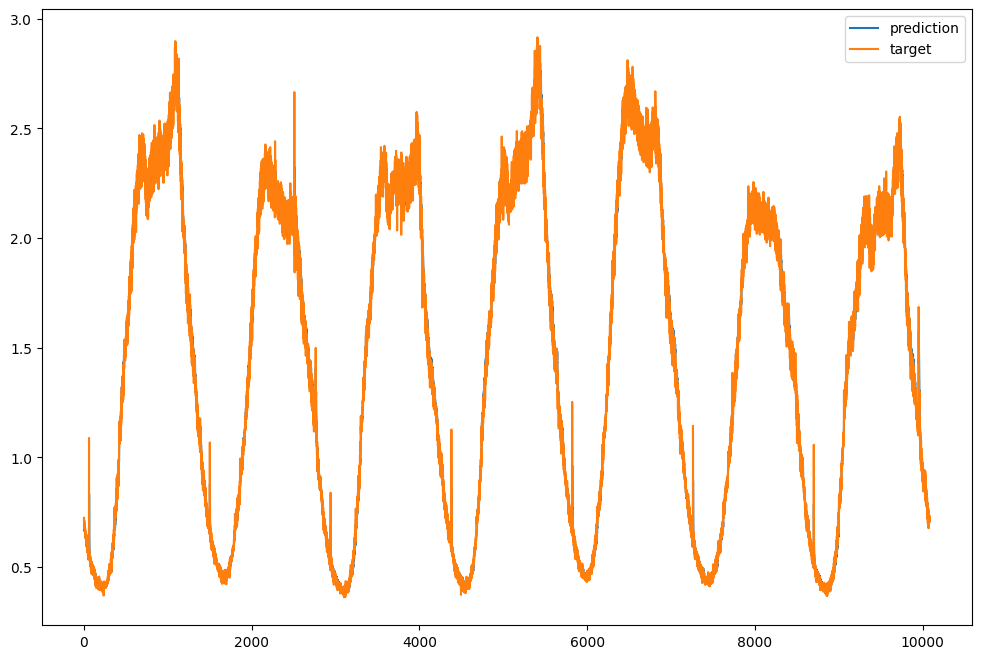

In [17]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [18]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 3.9723329544067383 %


SMAPE 0.35495781898498535 %

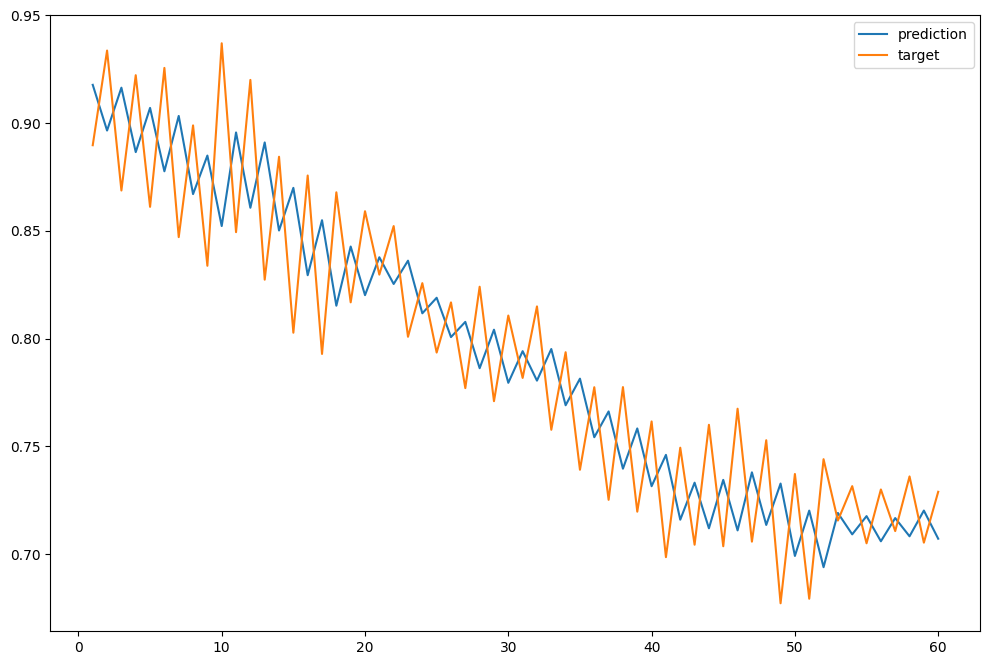

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

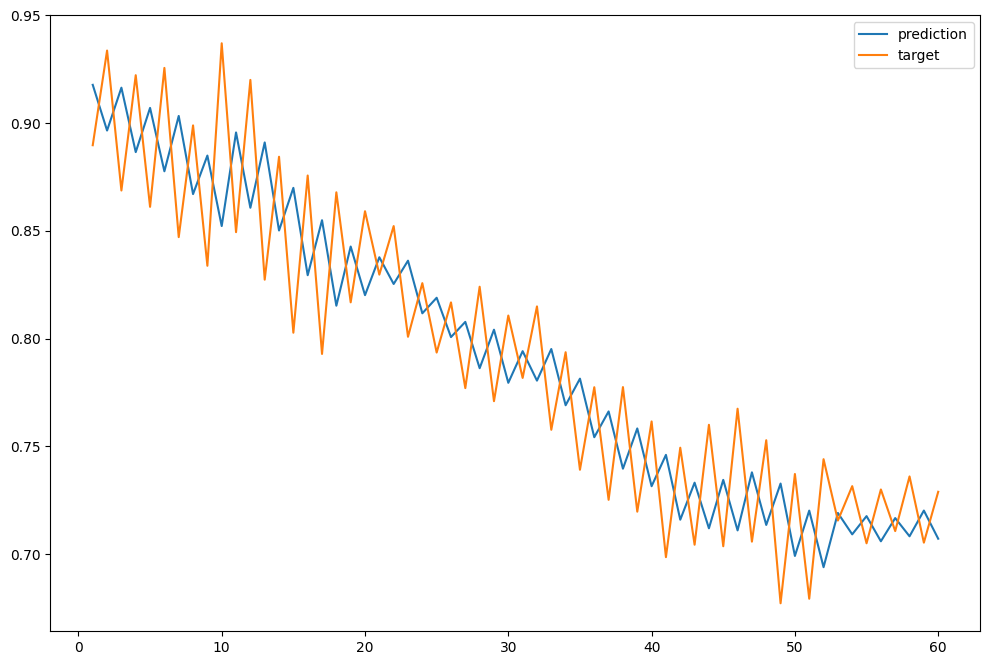

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [21]:
np.mean(time_list)

0.8671743319148109

<font color = blue><font size = 6> Conclusion </font></font><br>
DLienar online-learning과 NLinear online-learning에 비하면 매우 안좋은 SMAPE값이다 또한 한번 훈련하는데 0.6초가 걸렸는데 이는 속도가 무려 3배나 느리다는 것을 알려준다